<a href="https://colab.research.google.com/github/dddonghwa/deep-learning-with-python/blob/main/%08ch5_01_convnet_small_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 5장. 컴퓨터 비전을 위한 딥러닝
## 5.1 합성곱 신경망 소개

In [ ]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28,1)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-traina

마지막 층의 (3,3,64) 크기의 출력 텐서를 완전 연결 레이어(Fully Connected Layer/Network)에 입력함 = `layers.Dense()`   
FC layer는 1차원이기 때문에 3차원의 출력을 1차원으로 펼쳐야 함 → `Flatten()`  
그 다음 2개의 Dense 층을 추가, 10개의 클래스 분류하기 위해 마지막 층의 출력을 10개로 지정


In [ ]:
# 코드 5-2 컨브넷 위에 분류기 추가
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [ ]:
# 코드 5-3 MNIST 이미지에 컨브넷 훈련하기
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [ ]:
from tensorflow.keras.utils import to_categorical # one hot encoder
train_images = train_images.reshape((60000, 28,28,1))
train_images = train_images.astype('float32')/255.

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32')/255.

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels,
          batch_size=64, epochs=5)

Epoch 1/5
938/938 [==============================] - 7s 5ms/step - loss: 0.1680 - accuracy: 0.9472
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0459 - accuracy: 0.9855
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0316 - accuracy: 0.9906
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0235 - accuracy: 0.9926
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0191 - accuracy: 0.9945


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

# cf. 2층 FC Network 테스트 세트 정확도 : 97.97%

313/313 [==============================] - 1s 3ms/step - loss: 0.0318 - accuracy: 0.9915
0.9915000200271606


### 5.1.1 합성곱 연산
ConvNet의 성질
- 학습된 패턴은 평행 이동 불변성을 가진다.  
이미지의 특정 부분에서 패턴을 학습했다면 다른 곳에서도 동일한 패턴을 인식할 수 있음
- 패턴의 공간적 계층 구조를 학습할 수 있다.  
첫 번째 Conv 레이어가 작은 지역의 패턴을 학습하면 두 번째 Conv 레이어가 첫 번째 레이어가 추출한 특성으로 구성된 더 큰 지역의 패턴을 학습함  
수용영역의 넓이가 점점 커짐


### 5.1.2 최대 풀링 연산 (Max Pooling)
2x2 window + stride=2 을 사용하여 최댓값을 추출, 입력 피처맵의 절반 크기로 다운샘플링  
왜 이런 식으로 할까?  
- ConvNet으로만 이루어진 네트워크는 층이 깊어져도 더 넓은 영역을 보지 못한다.(수용영역 관점에서) 더 큰 패턴을 찾아내는 것이 어렵다. → 피처의 공간적 계층 구조를 학습하는데 도움이 되지 않는다.
- 파라미터의 갯수가 너무 많아서 과적합 위험이 커진다.

평균 풀링(Average Pooling)보다는 최대 풀링이 더 잘 작동하는 편
- 이유 : ~~피처가 각 피처맵의 타일에서 어떤 패턴이나 개념의 존재 여부를 인코딩하는 경향이 있기 때문에~~, 피처의 평균값보다 여러 특성 중 최댓값을 사용하는 것이 더 유용

## 5.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기
- 적은 데이터셋의 기준 : 수백 ~ 수만 개 사이  

#### 예제
4000개의 강아지와 고양이 사진으로 구성된 데이터셋으로 강아지/고양이 분류기 만들기. 
#### 정확도 기록
- 기본 성능 → 71% 
- 데이터 증식 → 82% 향상
- 사전 훈련된 네트워크 사용 (Transfer learning) → 90% 향상
- 사전 훈련된 네트워크를 세밀하게 튜닝 (Fine-Tuning) → 92% 향상

### 5.2.1 작은 데이터셋 문제에서 딥러닝의 타당성
딥러닝 = 데이터 풍부할 때만 잘 작동 → 부분적으로 맞는말, 특히 입력 데이터가 이미지처럼 매우 고차원인 문제의 경우  
하지만, __훈련하려는 네트워크의 크기와 깊이에 따라 필요한 샘플의 갯수는 상대적__  
복잡한 구조의 네트워크에 수 백개의 샘플로 훈련은 불가능
간단한 구조의 네트워크에는 수 백개의 샘플로도 충분히 훈련 가능  

#### Kaggle 대회 : 강아지 vs 고양이 데이터셋 [링크](http://www.kaggle.com/c/dogs-vs-cats/data)

2.5만 개의 강아지, 고양이 이미지, 각 클래스마다 1.25만개  
클래스 당 훈련 셋 1000개, 검증 셋 500개, 테스트 셋 500개

In [ ]:
# dataset_small.zip 파일 올리기
from google.colab import files
file_uploaded = files.upload()

In [ ]:
# 5-4 훈련, 검증, 테스트 폴더로 이미지 복사하기
# 전체 이미지셋을 가져오는데 시간이 오래 걸려서 local에서 jupyternotebook으로 수행한 후에 dataset_small만 가져옴

# import os, shutil
# import os.path as osp

# original_dataset_dir = './datasets/cats_and_dogs/train'
# base_dir = './datasets/cats_and_dogs_small'
# os.mkdir(base_dir)

# train_dir = osp.join(base_dir, 'train')
# os.mkdir(train_dir)
# validation_dir = osp.join(base_dir, 'validation')
# os.mkdir(validation_dir)
# test_dir = osp.join(base_dir, 'test')
# os.mkdir(test_dir)

# train_cats_dir = osp.join(train_dir, 'cats')
# os.mkdir(train_cats_dir)
# train_dogs_dir = osp.join(train_dir, 'dogs')
# os.mkdir(train_dogs_dir)

# val_cats_dir = osp.join(val_dir, 'cats')
# os.mkdir(val_cats_dir)
# val_dogs_dir = osp.join(val_dir, 'dogs')
# os.mkdir(val_dogs_dir)

# test_cats_dir = osp.join(test_dir, 'cats')
# os.mkdir(test_cats_dir)
# test_dogs_dir = osp.join(test_dir, 'dogs')
# os.mkdir(test_dogs_dir)

# # 고양이
# fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
# for fname in fnames :
#   src = osp.join(original_dataset_dir, fname)
#   dst = osp.join(train_cats_dir, fname)
#   shutil.copyfile(src, dst)

# fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
# for fname in fnames :
#   src = osp.join(original_dataset_dir, fname)
#   dst = osp.join(val_cats_dir, fname)
#   shutil.copyfile(src, dst)
  
# fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
# for fname in fnames :
#   src = osp.join(original_dataset_dir, fname)
#   dst = osp.join(test_cats_dir, fname)
#   shutil.copyfile(src, dst)

# # 강아지
# fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
# for fname in fnames :
#   src = osp.join(original_dataset_dir, fname)
#   dst = osp.join(train_dogs_dir, fname)
#   shutil.copyfile(src, dst)

# fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
# for fname in fnames :
#   src = osp.join(original_dataset_dir, fname)
#   dst = osp.join(val_dogs_dir, fname)
#   shutil.copyfile(src, dst)
  
# fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
# for fname in fnames :
#   src = osp.join(original_dataset_dir, fname)
#   dst = osp.join(test_dogs_dir, fname)
#   shutil.copyfile(src, dst)

In [ ]:
# zip 파일 압축 풀기
import zipfile
    	
fantasy_zip = zipfile.ZipFile('/content/dataset_small.zip')
fantasy_zip.extractall('/content/')

fantasy_zip.close()

In [ ]:
import os
train_dir = './dataset_small/train'
test_dir = './dataset_small/test'
val_dir = './dataset_small/val'

train_cats_dir = './dataset_small/train/cats'
train_dogs_dir = './dataset_small/train/dogs'
test_cats_dir = './dataset_small/test/cats'
test_dogs_dir = './dataset_small/test/dogs'
val_cats_dir = './dataset_small/val/cats'
val_dogs_dir = './dataset_small/val/dogs'

# 고양이
print(len(os.listdir(train_cats_dir)))
print(len(os.listdir(test_cats_dir)))
print(len(os.listdir(val_cats_dir)))

# 강아지
print(len(os.listdir(train_dogs_dir)))
print(len(os.listdir(test_dogs_dir)))
print(len(os.listdir(val_dogs_dir)))

1000
500
500
1000
500
500


### 5.2.3 네트워크 구성하기

(Conv2D + Maxpooling2D)*3 + Conv2D + Dense*2  
입력 크기 : 150x150

In [ ]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 128)     

In [ ]:
# 5-6 모델의 훈련 설정하기
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### 5.2.4 데이터 전처리
1. 사진 파일 읽기
2. JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩
3. 부동 소수 타입의 텐서로 변환
4. 픽셀 값 (0~255)의 스케일을 [0,1]로 조정

`keras.preprocessing.image` 라이브러리 사용
- ImageDataGenerator 클래스 : 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어주는 파이썬 generator을 만들어줌

cf. 파이썬 generator
반복자(iterator)처럼 작동하는 객체로 for .. in 연산자에 사용할 수 있다.

In [ ]:
# 5-7 ImageDataGenerator를 사용하여 디렉토리에서 이미지 읽기
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # 타겟 디렉토리
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


150x150 이미지 x 20개(batch_size) = 하나의 미니배치 → 크기 : (20,150,150,3)  
이진 레이블 배치 → 크기 : (20,) 

In [ ]:
# generator가 생성하는 훈련 데이터와 레이블의 미니배치 크기 확인하기
for data_batch, labels_batch in train_generator :
  print(data_batch.shape)
  print(labels_batch.shape)
  break

(20, 150, 150, 3)
(20,)


#### fit_generator
`fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
` 
- generator : 입력과 타겟의 배치를 끝없이 반환하는 파이썬 제너레이터를 첫번째 변수로 입력
- steps_per_epoch :
  - 하나의 에포크를 정의하기 위해 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지 지정
  - steps_per_epoch 갯수만큼 generator로부터 미니배치를 뽑은 다음 steps_per_epoch 횟수만큼 경사 하강법 단계를 실행한 후 다음 에포크로 넘어감
  - 여기서는 20개의 샘플이 하나의 미니 배치이고 전체 2000개의 샘플이 있으므로 steps_per_epoch를 100으로 지정
- validation_data :
  - 데이터 제너레이터 혹은 넘파이 배열의 튜플
  - 데이터 제너레이터를 사용하는 경우 검증 데이터의 배치를 끝없이 반환하므로 얼마나 많은 배치를 추출하여 평가할지 validation_steps 변수에 지정

*__Q. 기존에는 fit(x,y, batch_size, epoch)만을 지정해주었다. 즉 generator를 사용하지는 않았는데 이번에 사용하는 이유가 뭘까?__*  
A. 데이터 전체를 로딩해줄 필요 없이 그때그때 필요한 배치 사이즈 만큼의 데이터만 불러들이기 위해서 generator를 사용한다.  

*__Q. steps_per_epoch/epoch이 헷갈린다.__*   
A. 기존에는 ImageDateGenerator 없이 전체 훈련데이터를 메모리에 올려놓고 배치 사이즈만 지정해서 끌어와썼다. 전체 훈련데이터의 샘플 수를 알기 때문에 한 epoch당 미니 배치를 몇번 추출해야하는지 알 수 있었다.   
예를 들어 MNIST 데이터셋은 훈련 데이터가 60000개 있고 배치 사이즈를 64개로 지정할 경우 6000//64개를 한 epoch으로 정의하면 되었다.  

그런데 전체 훈련 데이터가 너무 클 경우에는 ImageDataGenerator는 사용해야한다. ImageDataGenerator는 지정한 크기의 미니배치를 끝없이/랜덤으로 반환한다. (바로 위의 셀에 `break`를 제거하고 수행해보면 알 수 있다.) 따라서 한 epoch을 몇 번의 미니배치로 정의할 것인가가 중요하고 이를 steps_per_epoch라는 변수에 지정해준다. Cats&Dogs 예제와 같이 (전체 데이터셋 샘플 수/미니 배치 수)로 계산하는 것이 일반적인 것 같다.  

iteration/epoch/batch_size 개념이 헷갈린다면 [여기](https://losskatsu.github.io/machine-learning/epoch-batch/#2-batch-size%EC%9D%98-%EC%9D%98%EB%AF%B8)를 보자.

In [ ]:
# 5-8 배치 제너레이터를 사용하여 모델 훈련하기
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100,
    epochs=30, 
    validation_data= val_generator,
    validation_steps=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
100/100 [==============================] - 9s 87ms/step - loss: 0.4732 - accuracy: 0.7755 - val_loss: 0.5662 - val_accuracy: 0.7070
Epoch 2/30
100/100 [==============================] - 9s 86ms/step - loss: 0.4367 - accuracy: 0.8000 - val_loss: 0.5587 - val_accuracy: 0.7230
Epoch 3/30
100/100 [==============================] - 9s 86ms/step - loss: 0.4052 - accuracy: 0.8100 - val_loss: 0.6964 - val_accuracy: 0.6670
Epoch 4/30
100/100 [==============================] - 8s 85ms/step - loss: 0.3810 - accuracy: 0.8235 - val_loss: 0.5539 - val_accuracy: 0.7260
Epoch 5/30
100/100 [==============================] - 9s 86ms/step - loss: 0.3598 - accuracy: 0.8490 - val_loss: 0.5779 - val_accuracy: 0.7180
Epoch 6/30
100/100 [==============================] - 9s 88ms/step - loss: 0.3344 - accuracy: 0.8555 - val_loss: 0.6016 - val_accuracy: 0.7110
Epoch 7/30
100/100 [==============================] - 9s 87ms/step - loss: 0.3110 - accuracy: 0.8695 - val_loss: 0.5736 - val_accuracy: 0.7300

In [ ]:
# 5-9 모델 저장하기
model.save('./cats_and_dogs_small_1.h5')

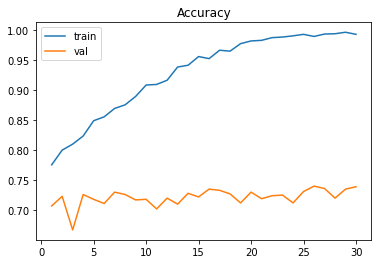

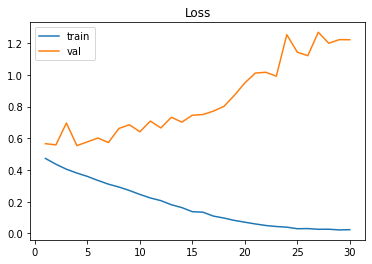

In [ ]:
# 5-10 훈련의 정확도와 손실 그래프 그리기
import matplotlib.pyplot as plt
import numpy as np

def history_plot(history_dict):
  acc = history_dict['accuracy']
  val_acc = history_dict[['val_accuracy']
  loss = history_dict[['loss']
  val_loss = history_dict[['val_loss']

  epochs = np.arange(1, len(acc)+1)
  plt.plot(epochs, acc, label='train')
  plt.plot(epochs, val_acc, label='val')
  plt.title('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, label='train')
  plt.plot(epochs, val_loss, label='val')
  plt.title('Loss')
  plt.legend()
  plt.show()

history_plot(history.history)

#### 해석
- 과대적합  
- 검증 정확도 70~72%에서 멈춤  


### 5.2.5 데이터 증식 사용하기
기존 훈련 샘플로부터 더 많은 훈련 데이터를 생성하여 과대적합을 막을 수 있음  
ImageDataGenerator가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정 가능

cf. ImageDataGenerator 기본 버전  
`datagen = ImageDataGenerator(rescale=1./255)`

공식 문서   
```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)
```

In [ ]:
# 5-11 ImageDataGenerator를 사용하여 데이터 증식 설정하기
datagen = ImageDataGenerator(
    rotation_range=20, # 이미지 회전 각도 범위
    width_shift_range=0.1, # 수평 방향으로 평행 이동 (전체 너비에 대한 비율)
    height_shift_range=0.1, # 수직 방향으로 평행 이동 (전체 높이에 대한 비율)
    shear_range = 0.1, # 전단(shearing transformation) 각도 범위
    zoom_range=0.1, # 이미지 확대 범위
    horizontal_flip = True, # 수평으로 뒤집기
    fill_mode='nearest') # 회전/가로•세로 이동에 의해 새롭게 생성해야할 픽셀을 채울 전략

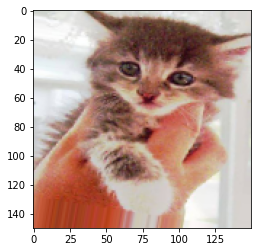

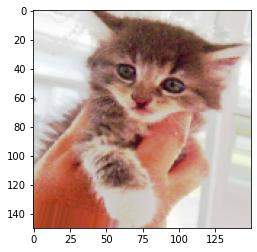

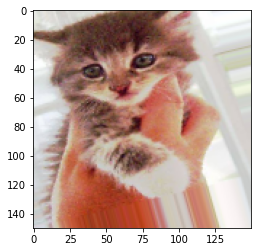

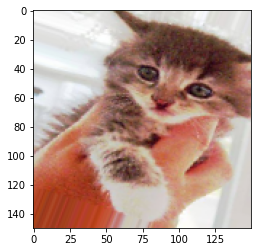

In [ ]:
# 5-12 랜덤하게 증식된 훈련 이미지 그리기
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]) 
img_path = fnames[3] # 증식할 이미지 선택

img = image.load_img(img_path, target_size=(150,150)) # 이미지 읽고 크기 변경
x = image.img_to_array(img)
x = x.reshape((1,)+x.shape) # (1,150,150,3)으로 변경

i=0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%4 == 0 :
    break
  
plt.show()


데이터 증폭을 하더라도 동일한 이미지이므로 이미지 사이의 상호연관성을 무시할 수 없다. 
따라서 과대적합을 제거하기에는 충분하지 않을 수 있기 때문에 네트워크의 FC layer 직전에 Dropout 층을 추가한다.

In [56]:
# 5-13 드롭아웃을 포함한 새로운 컨브넷 정의하기
from keras import models, layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer = optimizers.RMSprop(1e-5),
              metrics=['accuracy'])

In [57]:
# CAUTION! takes around 30 mins!
# 5-14 데이터 증식 제너레이터를 사용하여 컨브넷 훈련하기

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data = val_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
100/100 [==============================] - 22s 210ms/step - loss: 0.6928 - accuracy: 0.5080 - val_loss: 0.6915 - val_accuracy: 0.5280
Epoch 2/100
100/100 [==============================] - 21s 206ms/step - loss: 0.6922 - accuracy: 0.5120 - val_loss: 0.6908 - val_accuracy: 0.5430
Epoch 3/100
100/100 [==============================] - 21s 207ms/step - loss: 0.6893 - accuracy: 0.5365 - val_loss: 0.6883 - val_accuracy: 0.5390
Epoch 4/100
100/100 [==============================] - 20s 205ms/step - loss: 0.6884 - accuracy: 0.5485 - val_loss: 0.6852 - val_accuracy: 0.5200
Epoch 5/100
100/100 [==============================] - 21s 207ms/step - loss: 0.6862 - accuracy: 0.5575 - val_loss: 0.6847 - val_accuracy: 0.5040
Epoch 6/100
100/100 [==============================] - 21s 207ms/step - loss: 0.6825 - accuracy: 0.5550 - val_loss: 0.6788 - val_accuracy: 0.5730
Epoch 7/100
100/100 [==============================] - 21s 207ms/step - loss: 0.6801 - accuracy: 0.5740 - val_loss: 0.6758 -

In [58]:
model.save('./cats_and_dogs_small_2.h5')

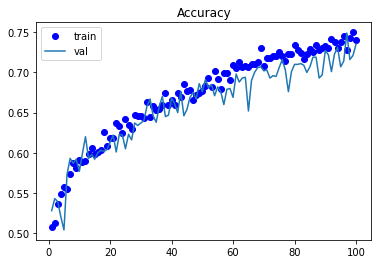

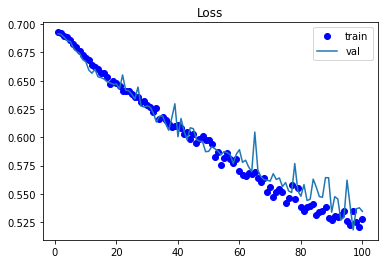

In [59]:
def history_plot(history_dict):
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = np.arange(1, len(acc)+1)
  plt.plot(epochs, acc, 'bo', label='train')
  plt.plot(epochs, val_acc, label='val')
  plt.title('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'bo', label='train')
  plt.plot(epochs, val_loss, label='val')
  plt.title('Loss')
  plt.legend()
  plt.show()

history_plot(history.history)